## Data processing 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# columns
c_year = 'year'
c_district = 'District'
c_amount = 'Amount in USD (nominal)'
c_country = 'Financier Country'
c_population = 'Population (in 1000)'
c_aid_pc = 'Aid per capita'
c_gov_spend = 'Government Expenditure by district in thousands (year 2013)'
c_gov_spend_pc = 'Government Spending per Capita in thousands (year 2013)'
c_cum_vic = 'Cumulative Victory Margin (average)'
c_gdp = 'GDP (Value Added) Rs. in million (2013)'
c_gdp_usd = 'GDP USD'
c_hdi = 'HDI (2013)'
c_location = 'Location'
c_ethn = 'Ethnicity'
c_distance_too_long = """Distance to closest border crossing in km (India: Banbasa, India - Kanchanpur District, Nepal;
    Rupaidiha, India - Banke District, Nepal;
    Sonauli, India - Rupandehi District, Nepal;
    Raxaul, India - Birgunj, Nepal (also known as the 'Gateway of Nepal');
    Bhitthamore,India - Mahottari District, Nepal;
    Jogbani, India - Biratnagar, Nepal;
    Panitanki, India - Kakarbhitta, Nepal) (China: Gyirong, China –Rasuwa, Nepal; Zhangmu, China – Kodari, Nepal)"""
c_distance = "Distance to closest border"

# values
v_china = 'China (People\'s Republic of)'
v_india = 'India'

In [2]:
# aid dataset
aid = pd.read_csv('data/aid_projects.csv')
aid[c_year] = aid['Commitment Year']
aid[c_distance] = aid[c_distance_too_long]
aid = aid.drop(['Title', 'Sector Name', 'Funding Agencies', 'Source URLs', 'Commitment Year', c_distance_too_long], axis=1)

# aid data-cleaning
aid[c_distance] = aid[c_distance].str.replace(',', '.')
aid[c_distance] = aid[c_distance].astype(float)

# aid tranformations
aid[c_aid_pc] = aid[c_amount] / aid[c_population]
aid[c_gov_spend_pc] = aid[c_gov_spend] / aid[c_population]
aid[c_gdp_usd] = aid[c_gdp] * 0.0118 * 1e6

# aid split
aid_first = aid[aid[c_year] <= 2012]
aid_second = aid[aid[c_year] > 2012]


In [3]:
# win dataset
win_first = pd.read_csv('data/winning_candidates_2064.csv')
win_second = pd.read_csv('data/winning_candidates_2070.csv')
win_first[c_year] = 2008
win_second[c_year] = 2013
win = pd.concat([win_first, win_second])

# win data cleaning
win[c_cum_vic] = win[c_cum_vic].str.replace(',', '.') 
win[c_cum_vic] = win[c_cum_vic].str.replace('%', '')
win[c_cum_vic] = win[c_cum_vic].astype(float)
win[c_cum_vic] = win[c_cum_vic] / 100

# win split
win_first = win[win[c_year]== 2008]
win_second = win[win[c_year] == 2013]

In [4]:
def get_distr_sum(df: pd.DataFrame, col):
    districts = df[[c_district, col]]
    districts = districts.groupby([c_district]).sum()
    return districts.sort_values(by=col, ascending=False)

def get_distr_mean(df: pd.DataFrame, col):
    districts = df[[c_district, col]]
    districts = districts.groupby([c_district]).mean()
    return districts.sort_values(by=col, ascending=False)

def get_location_mean(df: pd.DataFrame, col):
    locations = df[[c_location, col]]
    locations = locations.groupby([c_location]).mean()
    return locations.sort_values(by=col, ascending=False)

def get_stats(df: pd.DataFrame, col, distr_fun=get_distr_sum, show_split=True):
    distr = distr_fun(df, col)
    
    mean = distr.mean().to_numpy()
    sd = distr.std().to_numpy()
    min = distr.min().to_numpy()
    max = distr.max().to_numpy()
    mean_first = distr_fun(df[df[c_year] <= 2012], col).mean().to_numpy()
    mean_second = distr_fun(df[df[c_year] > 2012], col).mean().to_numpy()
    arr = np.array([mean, sd, min, max, mean_first, mean_second]).flatten()
    if show_split: 
        return arr
    else:
        return arr[:4]

In [5]:
stats_aid_pc = np.log10(get_stats(aid, c_aid_pc)) 

# china
aid_china = aid[aid[c_country] == v_china]
stats_aid_pc_china = np.log10(get_stats(aid_china, c_aid_pc))
aid_china_tamang = aid_china[aid_china[c_ethn] == 'Tamang']
stats_aid_pc_china_tamang = np.log10(get_stats(aid_china_tamang, c_aid_pc))

# india
aid_india = aid[aid[c_country] == v_india]
stats_aid_pc_india = np.log10(get_stats(aid_india, c_aid_pc))
aid_india_tharu_yadav = aid_india[(aid_india[c_ethn] == 'Tharu') | (aid_india[c_ethn] == 'Yadav')]
stats_aid_pc_india_tharu_yadav = np.log10(get_stats(aid_india_tharu_yadav, c_aid_pc))

stats_cum_vic = get_stats(win.dropna(subset=[c_cum_vic]), c_cum_vic, get_distr_mean)
stats_distance = get_stats(aid, c_distance, get_location_mean, False)
stats_population = np.log10(get_stats(aid, c_population, get_distr_mean, False))
# gov-spend is in thousands, so times 1000
stats_gov_spend_pc = np.log10(get_stats(aid, c_gov_spend_pc, get_distr_mean, False) * 1e3)
stats_gdp = np.log10(get_stats(aid, c_gdp_usd, get_distr_mean, False))
stats_hdi = get_stats(aid, c_hdi, get_distr_mean, False)


In [6]:
stats = pd.DataFrame(
[
    stats_aid_pc,
    stats_aid_pc_china,
    stats_aid_pc_china_tamang,
    stats_aid_pc_india,
    stats_aid_pc_india_tharu_yadav,
    stats_cum_vic,
    stats_distance,
    stats_population,
    stats_gov_spend_pc,
    stats_gdp,
    stats_hdi
], 
columns=['Mean', 'SD', 'Min', 'Max', 'Mean First', 'Mean Second'], 
index=[
    'Aid per Capita (log)', 
    'Chinese Aid per Capita (log)', 
    'Chinese Co-Ethnic District (log)',
    'Indian Aid per Capita (log)', 
    'Indian Co-Ethnic District (log)',
    'Victory Margin', 
    'Distance to closest border [km]',
    'Population (log)', 
    'Government spending per Capita (log)',
    'GDP per district (log)',
    'Human Development Index'
])

stats

,Mean,SD,Min,Max,Mean First,Mean Second
Aid per Capita (log),2.577973,3.389697,-0.794409,4.315437,1.357654,2.562715
Chinese Aid per Capita (log),3.188639,3.692448,-1.881798,4.315122,1.599184,3.588763
Chinese Co-Ethnic District (log),3.206366,3.388321,-1.881798,3.720308,2.172118,3.465283
Indian Aid per Capita (log),0.895753,1.110969,-0.794409,1.867799,1.018034,0.515798
Indian Co-Ethnic District (log),1.420161,1.304979,0.808505,1.867799,1.167610,1.064553
Victory Margin,0.073837,0.127800,-0.164650,0.463750,0.136807,0.013656
Distance to closest border [km],138.510243,138.870263,0.000000,1013.000000,NaN,NaN
Population (log),5.503216,5.416975,3.789651,6.212890,NaN,NaN
Government spending per Capita (log),3.769218,3.787907,3.288111,4.607180,NaN,NaN
GDP per district (log),8.311482,8.458915,6.998739,9.365737,NaN,NaN


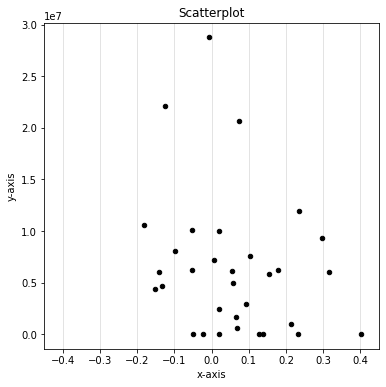

In [82]:
def scatter_plot(x, y):
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)
    
    ax.set_axisbelow(True)
    
    ax.grid(axis='x', color='#ddd')
    ax.scatter(x, y, s=20, c='black')
    ax.set_xbound(-0.45, 0.45)
    ax.set_title('Scatterplot')
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    
    fig.savefig('test.jpg', bbox_inches='tight', dpi=200, format='jpg')



margin = get_distr_mean(margin, c_cum_vic).dropna()
amount = get_distr_sum(amount, c_amount)
joined = margin.join(amount).dropna()
x = joined[c_cum_vic].to_numpy()
y = joined[c_amount].to_numpy()

scatter_plot(win_first, aid_first[aid_first[c_country] == v_india])
#scatter_plot(win_second, aid_second[aid_second[c_country] == v_india])


#scatter_plot(win_first, aid_first[aid_first[c_country] == v_china])
#scatter_plot(win_second, aid_second[aid_second[c_country] == v_china])
#scatter_plot(win, aid[aid[c_country] == v_india])




In [ ]:
# dist = aid[c_distance].to_numpy()
# amount = aid[c_amount].to_numpy()
# A = np.vstack([dist, np.ones(len(dist))]).T

# m, q = np.linalg.lstsq(A, amount, rcond=None)[0]
# plt.scatter(dist, amount)
# x = np.arange(np.min(dist), np.max(dist), 0.01)
# plt.plot(x, m * x + q)
# plt.show()

#aid[aid[c_country == v_china]]

#get_distr_sum(aid_first[aid_first[c_country] == v_china], c_amount)